In [36]:
using Plots
using LightGraphs
using LinearAlgebra
using BenchmarkTools
using SparseArrays
using Random
using LaTeXStrings
using Flux
using GraphRecipes
using GraphPlot

In [37]:
function randomPopulateMat(mat,symmetric=true)
    for ii = 1:round(Int, percPopulate*size(mat)[1] )
        row_tmp = rand( 1:size(mat)[1] )
        col_tmp = rand( 1:size(mat)[1] )
        if( row_tmp == col_tmp )
            col_tmp = rand( deleteat!( collect(1:size(mat)[1]), row_tmp ) )            
        end
        mat[row_tmp,col_tmp] = 1
        if(symmetric == true)
            mat[col_tmp,row_tmp] = 1
        end
    end
    return mat
end

randomPopulateMat (generic function with 2 methods)

In [38]:
function A2S(AdjMat)
    AdjMat += I #add the identity to the diagonal, add self-loops
    diag = Diagonal(vec(sum(AdjMat,dims=2) .^ (-1/2)))
    return (diag) * AdjMat * (diag) #return the normalized S matrix
end

A2S (generic function with 1 method)

In [39]:
function A2k(SMat,k)
    return SMat^k
end

A2k (generic function with 1 method)

In [40]:
BenchmarkTools.DEFAULT_PARAMETERS.samples = 20
BenchmarkTools.DEFAULT_PARAMETERS.seconds = 5

5

In [41]:
benchmarkDicts = Dict()
benchmarkDicts["time"] = []
benchmarkDicts["memory"] = []
benchmarkDicts["gctime"] = []
benchmarkDicts["allocs"] = []
NN = [10^k for k in 1:5] #[10^1,10^2,10^3,10^4,10^5]
percPopulate = 0.1
for ii in 1:length(NN)
    NNtmp = NN[ii]
    AA = spzeros(NNtmp,NNtmp);
    AA = randomPopulateMat(AA);
    bb = @benchmark A2S($AA)
    push!(benchmarkDicts["time"],mean(bb).time)
    push!(benchmarkDicts["memory"],mean(bb).memory)
    push!(benchmarkDicts["gctime"],mean(bb).gctime)
    push!(benchmarkDicts["allocs"],mean(bb).allocs)
    
end

In [42]:
benchmarkDicts["time"]

5-element Vector{Any}:
   1635.8300000000002
  10425.333333333332
  72645.05
 619153.65
      6.63738915e6

In [43]:
benchmarkDicts["memory"]

5-element Vector{Any}:
     2656
    14048
   124896
  1227712
 12261648

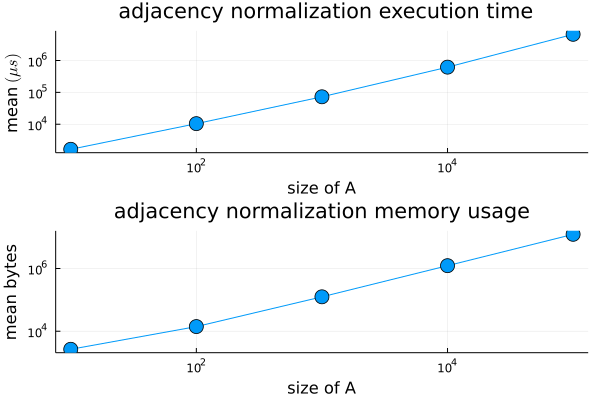

In [44]:
pTime = plot( NN , benchmarkDicts["time"] ,markershape=:circle, markersize=8 ,
        legend = false , xaxis=:log , yaxis=:log)
xlabel!("size of A")
ylabel!("mean " * L"(\mu s)")
title!(" adjacency normalization execution time")
pMemory = plot( NN , benchmarkDicts["memory"] ,markershape=:circle, markersize=8 ,
        legend = false , xaxis=:log , yaxis=:log)
xlabel!("size of A")
ylabel!("mean bytes")
title!("adjacency normalization memory usage")
plot(pTime, pMemory, layout = Plots.grid(2,1) )

In [45]:
benchmarkDicts_k = Dict()
benchmarkDicts_k["time"] = []
benchmarkDicts_k["memory"] = []
benchmarkDicts_k["gctime"] = []
benchmarkDicts_k["allocs"] = []
NN = [10^6]
percPopulate = 0.1
NNtmp = NN[1]
AA = spzeros(NNtmp,NNtmp);
AA = randomPopulateMat(AA);
AS = A2S(AA)
K = [0,1,2,3,4,6]
for ii in 1:length(K)
    kk = K[ii]
    bb = @benchmark A2k(AS,$kk)
    push!(benchmarkDicts_k["time"],mean(bb).time)
    push!(benchmarkDicts_k["memory"],mean(bb).memory)
    push!(benchmarkDicts_k["gctime"],mean(bb).gctime)
    push!(benchmarkDicts_k["allocs"],mean(bb).allocs)
    
end

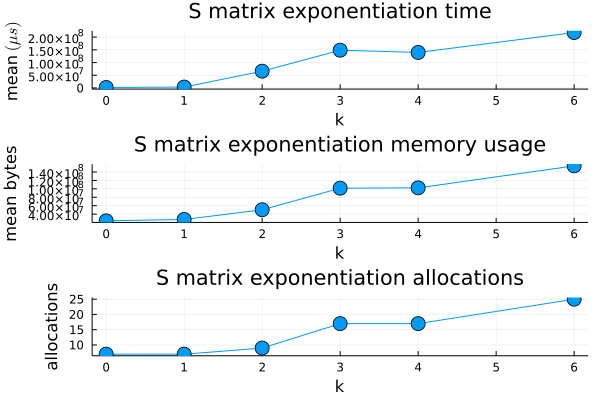

In [66]:
pTime = plot( K , benchmarkDicts_k["time"] ,markershape=:circle, markersize=8 ,
        legend = false )
xlabel!("k")
ylabel!("mean " * L"(\mu s)")
title!("S matrix exponentiation time")
pMemory = plot( K , benchmarkDicts_k["memory"] ,markershape=:circle, markersize=8 ,
        legend = false )
xlabel!("k")
ylabel!("mean bytes")
title!("S matrix exponentiation memory usage")
pAllocs = plot( K , benchmarkDicts_k["allocs"] ,markershape=:circle, markersize=8 ,
        legend = false )
xlabel!("k")
ylabel!("allocations")
title!("S matrix exponentiation allocations")
plot(pTime, pMemory, pAllocs, layout = Plots.grid(3,1) )

In [104]:
NN_set = [10^k for k in 2:5];

In [105]:
ER_graphs = Dict()
BA_graphs = Dict()
SF_graphs = Dict()
for nn in 1:length(NN_set)

    ER_graphs[nn] = erdos_renyi( NN_set[nn] , 5*(NN_set[nn]) )
    BA_graphs[nn] = barabasi_albert( NN_set[nn] , 4 )
    SF_graphs[nn] = static_scale_free( NN_set[nn] , 5*(NN_set[nn]) , 3 )
    
end
ER_graphs
#BA_graphs
#SF_graphs

Dict{Any, Any} with 4 entries:
  4 => {100000, 500000} undirected simple Int64 graph
  2 => {1000, 5000} undirected simple Int64 graph
  3 => {10000, 50000} undirected simple Int64 graph
  1 => {100, 500} undirected simple Int64 graph

In [106]:
SF_graphs

Dict{Any, Any} with 4 entries:
  4 => {100000, 500000} undirected simple Int64 graph
  2 => {1000, 5000} undirected simple Int64 graph
  3 => {10000, 50000} undirected simple Int64 graph
  1 => {100, 500} undirected simple Int64 graph

In [58]:
net_WS = watts_strogatz(50, 4, 0.3)

{50, 100} undirected simple Int64 graph

In [72]:
@benchmark A2S(AA)

BenchmarkTools.Trial: 100 samples with 6 evaluations.
 Range (min … max):   6.906 μs …  14.133 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):      9.935 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   10.012 μs ± 751.256 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

                             ▂█▃▆▂▆█▂  ▅ █                      
  ▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▄▁▁▁▁▁▁▇███████████▇█▅▇▄▅▄▁▁▁▁▁▁▁▁▁▁▄▁▁▁▄ ▄
  6.91 μs         Histogram: frequency by time         12.4 μs <

 Memory estimate: 13.77 KiB, allocs estimate: 22.

In [7]:
function adjacency2Smatrix(AdjMat)
    Adj = deepcopy(AdjMat)
    #make the diagonal for the adj matrix
    diag1 = zeros(size(Adj)[1],size(Adj)[2])
    [diag1[i,i]=1 for i in 1:size(diag1)[1]] 
    #add self-loops as the paper describes
    Adj .+= diag1
    #get degree matrix
    degrees = sum(Adj,dims=2)
    diag2 = zeros(size(Adj)[1],size(Adj)[2])
    [diag2[i,i]=degrees[i] for i in 1:size(diag1)[1]] 
    #make the diagonal matrix to the power of -1/2
    diag2 = diag2^(-1/2)
    #make the normalized S matrix
    S = diag2 * Adj * diag2
    return S
end

adjacency2Smatrix (generic function with 1 method)

In [9]:
as = adjacency2Smatrix(aa);
println(sum( (as)^1 ))
#println(sum( (as)^10 ))
#println(sum( (as)^100 ))
@btime adjacency2Smatrix(aa);

79.96632649518878
79.97113699635344
79.97113699587598
  64.377 μs (115 allocations: 260.78 KiB)


In [181]:
#now some synthetic data

In [118]:
function vizMatrixNormed(Adj,powerInd)#multiple dispatch
    global NN1
    hAdjNN1 = heatmap(Adj,title="Normalized Adjacency (S), k=$(powerInd)",
        showaxis=true,yaxis=:flip,aspect_ratio=1.0,
        framestyle=:box,xlims=(0.0,NN1+1.0),
        legend=true,ylims=(0.0,NN1+0.5),
        yticks=0:5:NN1,xticks=0:5:NN1,
        fill=cgrad([:white,:black]))
    return hAdjNN1
end

vizMatrixNormed (generic function with 1 method)

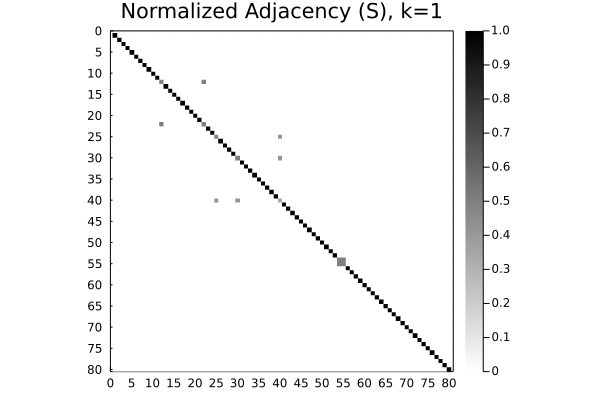

In [123]:
#adjMatrixNorm = adjacency2Smatrix(deepcopy(adjMatrix))
NN1 = 80
hVarX2 = vizMatrixNormed(as,1)

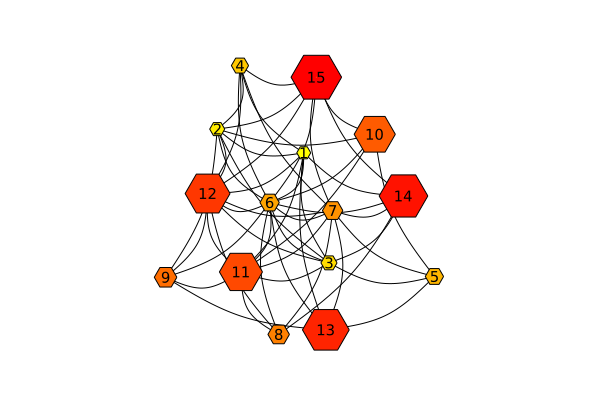

In [62]:
using GraphRecipes
using Plots

const n = 15
const A = Float64[ rand() < 0.5 ? 0 : rand() for i=1:n, j=1:n]
for i=1:n
    A[i, 1:i-1] = A[1:i-1, i]
    A[i, i] = 0
end

graphplot(A,
          markersize = 0.2,
          node_weights = 1:n,
          markercolor = range(colorant"yellow", stop=colorant"red", length=n),
          names = 1:n,
          fontsize = 10,
          linecolor = :darkgrey
          )